In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats
import calendar

import pandas as pd

%matplotlib inline

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.


Minimum with Nelder-Mead 
  final_simplex: (array([[-0.08986599,  0.71268205],
       [-0.08980205,  0.71263734],
       [-0.08978193,  0.71269785]]), array([-1.03162845, -1.03162845, -1.03162842]))
           fun: -1.0316284464752081
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 40
        status: 0
       success: True
             x: array([-0.08986599,  0.71268205])

Value of the function --->  -1.0316284464752081
--------------------------------------------------------------

Minimum with Powell 
    direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [-6.21111406e-04,  4.70877838e-05]])
     fun: -1.0316284534898421
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 3
  status: 0
 success: True
       x: array([-0.08984201,  0.71265634])

Value of the function --->  -1.0316284534898421
--------------------------------------------------------------

Minimum with Newton CG 
      fun: -0.21546382438369216
    

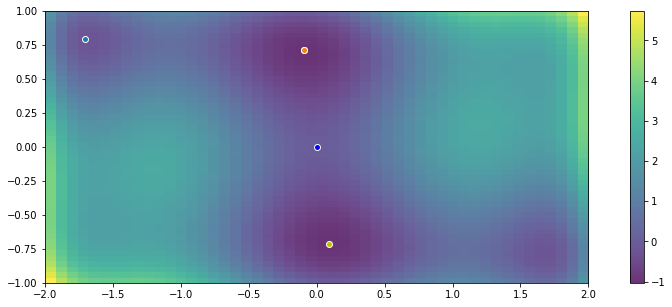

In [33]:
def func(x):
    return ( 4 - (2.1*(x[0]**2)) + ((x[0]**4)/3))*x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

x=np.linspace(-2,2)
y=np.linspace(-1,1)


xv, yv = np.meshgrid(x, y , sparse=True)



fig0=plt.figure(figsize=(15,5))
plt.imshow(func([xv, yv]), extent=[-2, 2, -1, 1], origin="lower" , alpha=0.8)
plt.colorbar()

x_min1 = optimize.minimize(func , x0 = [1,1] ,method='Nelder-Mead')
plt.scatter(x_min1.x[0] , x_min1.x[1] , c='r' , edgecolor='w')

x_min2 = optimize.minimize(func , x0 = [0,0] , method='Powell')
plt.scatter(x_min2.x[0] , x_min2.x[1] , c='C1' , edgecolor='w')

x_min3 = optimize.minimize(func , x0 = [-1.6,0.5] ,method='CG')
plt.scatter(x_min3.x[0] , x_min3.x[1] ,  edgecolor='w')

x_min4 = optimize.minimize(func , x0 = [0,0] , method='BFGS')
plt.scatter(x_min4.x[0] , x_min4.x[1] , c='b' , edgecolor='w')

x_min5 = optimize.minimize(func , x0 = [4,5] ,method='CG')
plt.scatter(x_min5.x[0] , x_min5.x[1] , c='y' , edgecolor='w')



print("\nMinimum with Nelder-Mead \n" , x_min1)
print("\nValue of the function ---> " ,x_min1.fun)
print("--------------------------------------------------------------")

print("\nMinimum with Powell \n" , x_min2)
print("\nValue of the function ---> ", x_min2.fun)

print("--------------------------------------------------------------")

print("\nMinimum with Newton CG \n" , x_min3)
print("\nValue of the function ---> ", x_min3.fun)
print("        LOCAL MINIMA DUE TO INITIAL GUESS          ")
print("--------------------------------------------------------------")

print("\nMinimum with BFGS \n" , x_min4)
print("\nValue of the function ---> " ,x_min4.fun)
print("        ERROR DUE TO INITIAL GUESS          ")

print("--------------------------------------------------------------")


print("\nMinimum with Newton CG \n" , x_min5)
print("\nValue of the function ---> ", x_min5.fun)

print("--------------------------------------------------------------")




The function has two global minima, but some of the methods of scipy.optimize.minimize() have a problems if the initial guess is putted as (x,y)=(0,0): in some cases in fact, they wrongly find the minimum in (0,0). Maybe becauase from (0,0) it can't understand the characteristic lenght of the problem that in general is related to the distance from the origin.

Text(0.5, 0.92, 'Six-hump Camelback function')

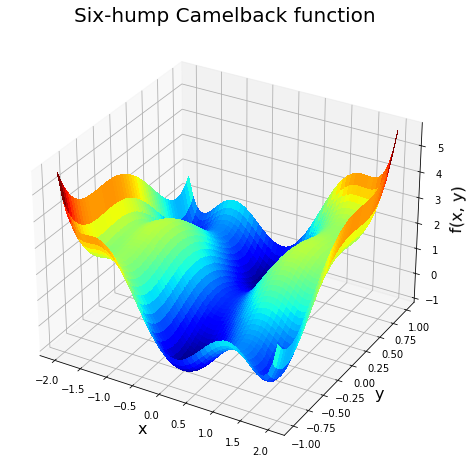

In [34]:

from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure( figsize=(20,8))
ax1 = fig1.add_subplot(111, projection='3d')
surf = ax1.plot_surface(xv, yv, func([xv, yv]), rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax1.set_xlabel('x' , fontsize=16)
ax1.set_ylabel('y' , fontsize=16)
ax1.set_zlabel('f(x, y)' , fontsize=16)
ax1.set_title('Six-hump Camelback function' , fontsize=20)



2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Time offset for T max: 5.74 +- 0.08
Time offset for T min: 6.16 +- 0.05

 Compability : 4.6 sigma => they are not the same within the fit accuracy


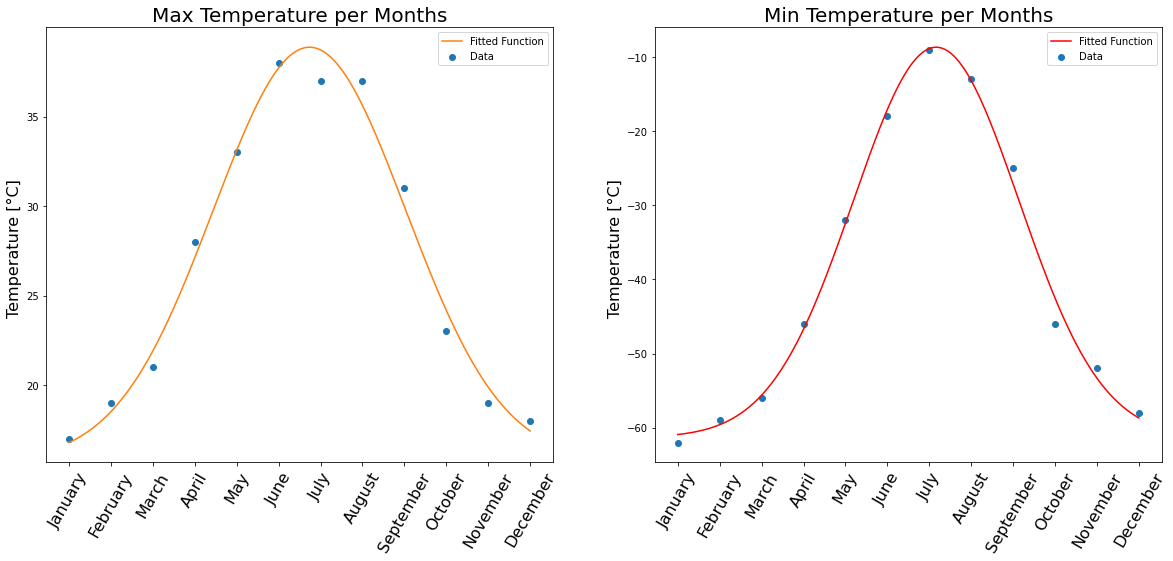

In [14]:

T_max= np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
T_min= np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

n_month=[x for x in range(0,12)]


fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize=(20,8))

ax[0].scatter(calendar.month_name[1:] , T_max , label='Data')
ax[0].set_title("Max Temperature per Months", fontsize=20)
ax[0].set_ylabel("Temperature [°C] " , fontsize=16)
ax[0].tick_params(axis='x', which='major', labelsize=16, rotation=60 )

ax[1].scatter(calendar.month_name[1:] , T_min , label='Data')
ax[1].set_title("Min Temperature per Months", fontsize=20)
ax[1].set_ylabel("Temperature [°C] " , fontsize=16)
ax[1].tick_params(axis='x', which='major', labelsize=16, rotation=60 )




def gaussian(x, A , mean , std , offset):
    return A * np.exp( - ((x - mean) **2 /(2*std**2))) + offset


x = np.linspace(0,11,1000)


popt_max , pcov_max  = optimize.curve_fit(gaussian, n_month, T_max, p0=[40, 7, 4, 0], full_output=False)

popt_min, pcov_min = optimize.curve_fit(gaussian, n_month, T_min , p0=[50, 7, 4, -60], full_output=False)




ax[0].plot(x, gaussian(x, *popt_max), color='C1', label='Fitted Function')
ax[0].legend(loc='best')


ax[1].plot(x, gaussian(x, *popt_min), color='r', label='Fitted Function')
ax[1].legend(loc='best')


# Is the time offset for min and max temperatures the same within the fit accuracy?
print("Time offset for T max: %4.2f +- %4.2f" %(popt_max[1], np.sqrt(pcov_max[1,1])))
print("Time offset for T min: %4.2f +- %4.2f" %(popt_min[1], np.sqrt(pcov_min[1,1])))


comp = abs(popt_max[1] - popt_min[1])/np.sqrt(pcov_max[1,1] + pcov_min[1,1])

print("\n Compability : %3.1f sigma => they are not the same within the fit accuracy"%(comp))



3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [36]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P /home/ilazza/LaboratoryOfComputationalPhysics_Y4/dataEs8/

--2021-12-15 15:50:43--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [segue]
--2021-12-15 15:50:43--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc94763fda63ed8d0add468aba94.dl.dropboxusercontent.com/cd/0/inline/Bb6Sikh5nsBHjz1WF-PqNtITlA1pn5gE0be6cuZWYDUk-Kgr7EoiUX3n5j6YHwAuJ8h7-PHgmgdnFSpDDLf4ZZk20N2NW3ZYbs-ntzYWzjeu9L6LKjkPSmVfk4JcqxFVHE8BPKO638mscZ0cBPhX1UC0/file# [segue]
--2021-12-15 15:50:44--  https://uc94763fda63ed8d0add468aba94.dl.dropboxusercontent.com/cd/0/inline/Bb6Sikh5nsBHjz1WF-PqNtITlA1pn5gE0be6cuZWYDUk-K

In [58]:
file_name='/home/ilazza/LaboratoryOfComputationalPhysics_Y4/dataEs8/residuals_261.pkl'

data = pd.read_pickle(file_name)

dataf=pd.DataFrame.from_dict(data , orient='index')



TypeError: len() of unsized object

In [ ]:
#Considering only the "residual" feature, 
#create an histogram with the appropriate binning and display it.




4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.